In [23]:
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
df = pd.read_csv('Dataset/umist_faces.csv')


In [25]:
df.shape

(575, 10305)

In [26]:
df.head()

label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0    1a    233.0    234.0    234.0    233.0    234.0    232.0    232.0   
1    1a    234.0    234.0    234.0    234.0    233.0    232.0    202.0   
2    1a    234.0    234.0    234.0    234.0    233.0    230.0    225.0   
3    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
4    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_7  pixel_8  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    168.0     99.0  ...        157.0        154.0        151.0        147.0   
1     98.0     79.0  ...        158.0        154.0        150.0        147.0   
2    109.0     85.0  ...        180.0        174.0        168.0        164.0   
3    232.0    229.0  ...        174.0        168.0        162.0        157.0   
4    234.0    229.0  ...        186.0        176.0        170.0        164.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        143.0        140.0        141.0        141.0        140.0   
1        141.0        140.0        137.0        138.0        137.0   
2        157.0        152.0        151.0        148.0        145.0   
3        155.0        150.0        144.0        144.0        142.0   
4        162.0        157.0        152.0        150.0        148.0   

   pixel_10303  
0        136.0  
1        137.0  
2        145.0  
3        143.0  
4        148.0  

[5 rows x 10305 columns]

In [27]:
# # df.duplicated()
# # Custom funciton to check for duplicates
# counter = 0
# # If the vaues are duplicated then the label is also gonna be same
# for i in range(len(df)):
#     for j in range(i+1, len(df)):
#         # Check for the same image if the labels are same
#         if(df.iloc[i, 0] == df.iloc[j, 0]):
#             # Check if the rows are same
#             if(df.iloc[i, 1:].equals(df.iloc[j, 1:])):
#                 print("Duplicate found")
#                 print(df.iloc[i, 0])
#                 print(df.iloc[j, 0])
#                 print("Row 1: ", df.iloc[i, 1:])
#                 print("Row 2: ", df.iloc[j, 1:])
#                 counter += 1
#                 print("\n\n")
                
# print("Total duplicates found: ", counter)
        

KeyboardInterrupt: 

In [ ]:
# Dropping the duplicates
df = df.drop_duplicates()
df.shape

(565, 10305)

In [ ]:
X = df.drop('label', axis=1).values
y = df['label']

In [ ]:
# Check if there are any duplicates
df.duplicated().sum()


0

In [ ]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

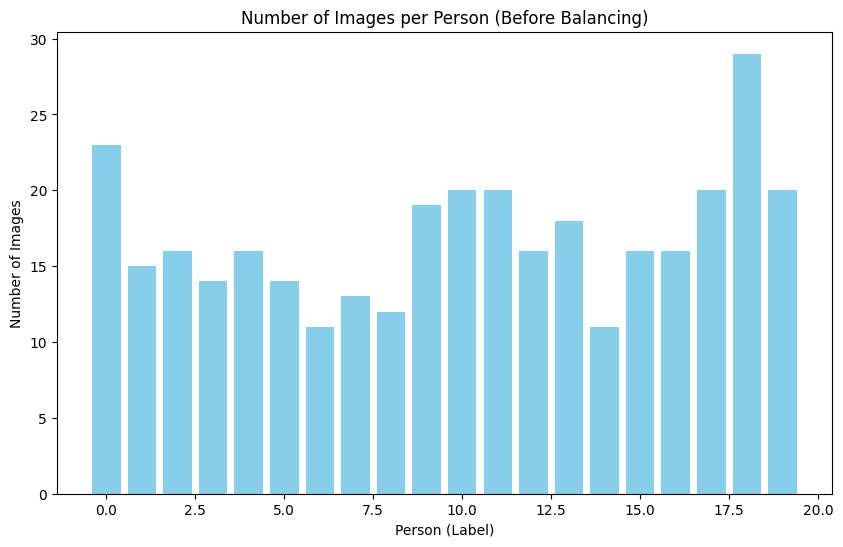

Balanced dataset shape: (960, 112, 92, 1), (960,)


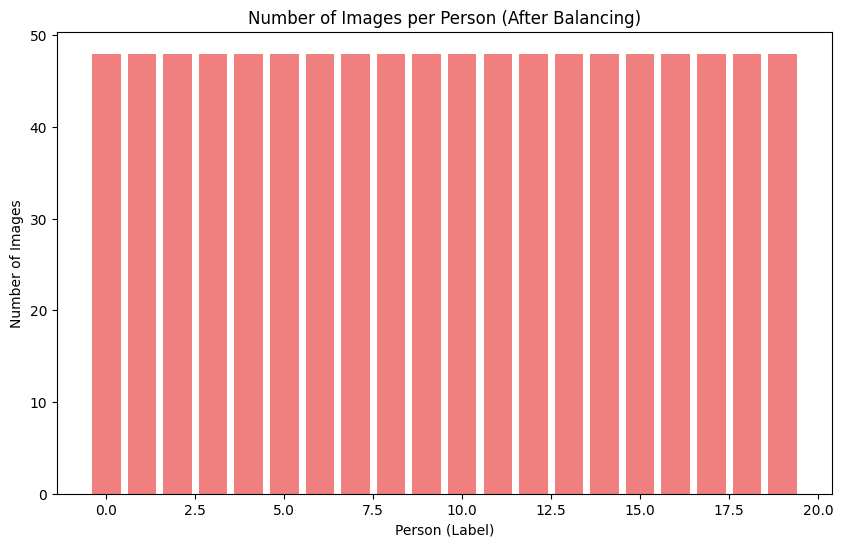

In [ ]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

// Preprocessing Steps

In [ ]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [ ]:
X_train

array([[ 1.28869537,  1.30761831,  1.30592712, ...,  1.56496564,
         1.58192109,  1.55333271],
       [ 1.28869537,  1.29246706,  1.30592712, ...,  1.58637299,
         1.60359256,  1.61890535],
       [ 1.28869537,  1.29246706,  1.30592712, ...,  1.05118927,
         0.9967912 ,  0.96317898],
       ...,
       [-1.21720578, -1.18241311, -1.15031505, ..., -0.49746905,
        -0.50978369, -0.50314861],
       [-1.86211681, -1.81515602, -1.77411566, ..., -0.96234277,
        -1.00543027, -1.01012471],
       [ 0.21792569,  0.2318794 ,  0.2502587 , ..., -1.17358984,
        -1.2140361 , -1.32312959]])

In [ ]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [ ]:
# Pca for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)



ValueError: Found array with dim 3. PCA expected <= 2.

In [ ]:
pca.explained_variance_ratio_.sum()

0.990112958129445

In [ ]:
X_train.shape

(576, 241)

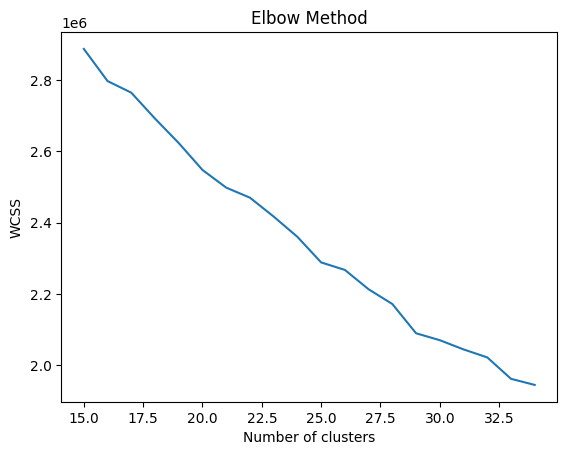

In [ ]:
# Find th best number of clusters
from sklearn.cluster import KMeans
# Silhouette score
from sklearn.metrics import silhouette_score

wcss = []
silhouette = []
for i in range(15, 35):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    y_kmeans = kmeans.predict(X_train)
    silhouette.append(silhouette_score(X_train, y_kmeans))
    


plt.plot(range(15, 35), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
# Best Silhouette score
best_score = np.argmax(silhouette) +15
print(best_score)

34


In [ ]:
# Try Kmeeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=33, random_state=0)

kmeans.fit(X_train)

y_kmeans = kmeans.predict(X_train)

# Checking the images in clusters

y_kmeans

array([ 3, 20, 20,  5, 18, 19, 29, 18, 32, 18, 21, 31,  5, 12, 18,  5,  3,
        1,  0,  2, 19, 14, 32,  4,  5,  9, 14,  0,  0, 29, 21,  2, 26, 18,
       19, 19,  0, 21,  5, 21, 15, 11,  5, 19, 15, 10, 16, 32, 32,  9, 18,
        2, 19, 17, 29,  1, 11,  6, 31, 26,  3, 30,  8,  2, 26,  1, 14, 16,
        0, 32, 29, 13, 17, 11, 13, 18,  4, 21,  9, 27, 21, 20, 20,  3, 18,
       20,  9, 15, 18,  6,  7, 13, 18, 29, 21, 21,  0,  5, 12, 16, 12,  5,
        7, 15,  0,  8,  7,  5, 22, 18,  1,  6, 21, 13, 10,  8,  1, 20, 32,
        5, 29, 32,  2,  2,  0, 23, 21, 13, 13,  0, 27,  0,  4,  9,  0,  0,
       19, 22, 21, 22,  7, 29, 10, 21, 24,  0,  3, 18,  1,  0, 17, 10, 22,
        3,  3, 20, 14, 24, 21, 13,  3, 18, 32, 25,  6,  4, 20, 12,  0, 10,
        2, 22,  9, 31, 19,  8, 30, 29, 29,  9, 16, 13, 21,  0, 12, 27, 30,
       12,  4, 25,  0,  0, 19, 10, 19, 14,  9, 18,  8, 27,  2, 19, 29,  9,
       17, 18,  7,  3, 19, 22, 28, 28, 28,  2,  3, 17,  4, 31, 26, 27, 11,
        8, 20, 21,  6, 21

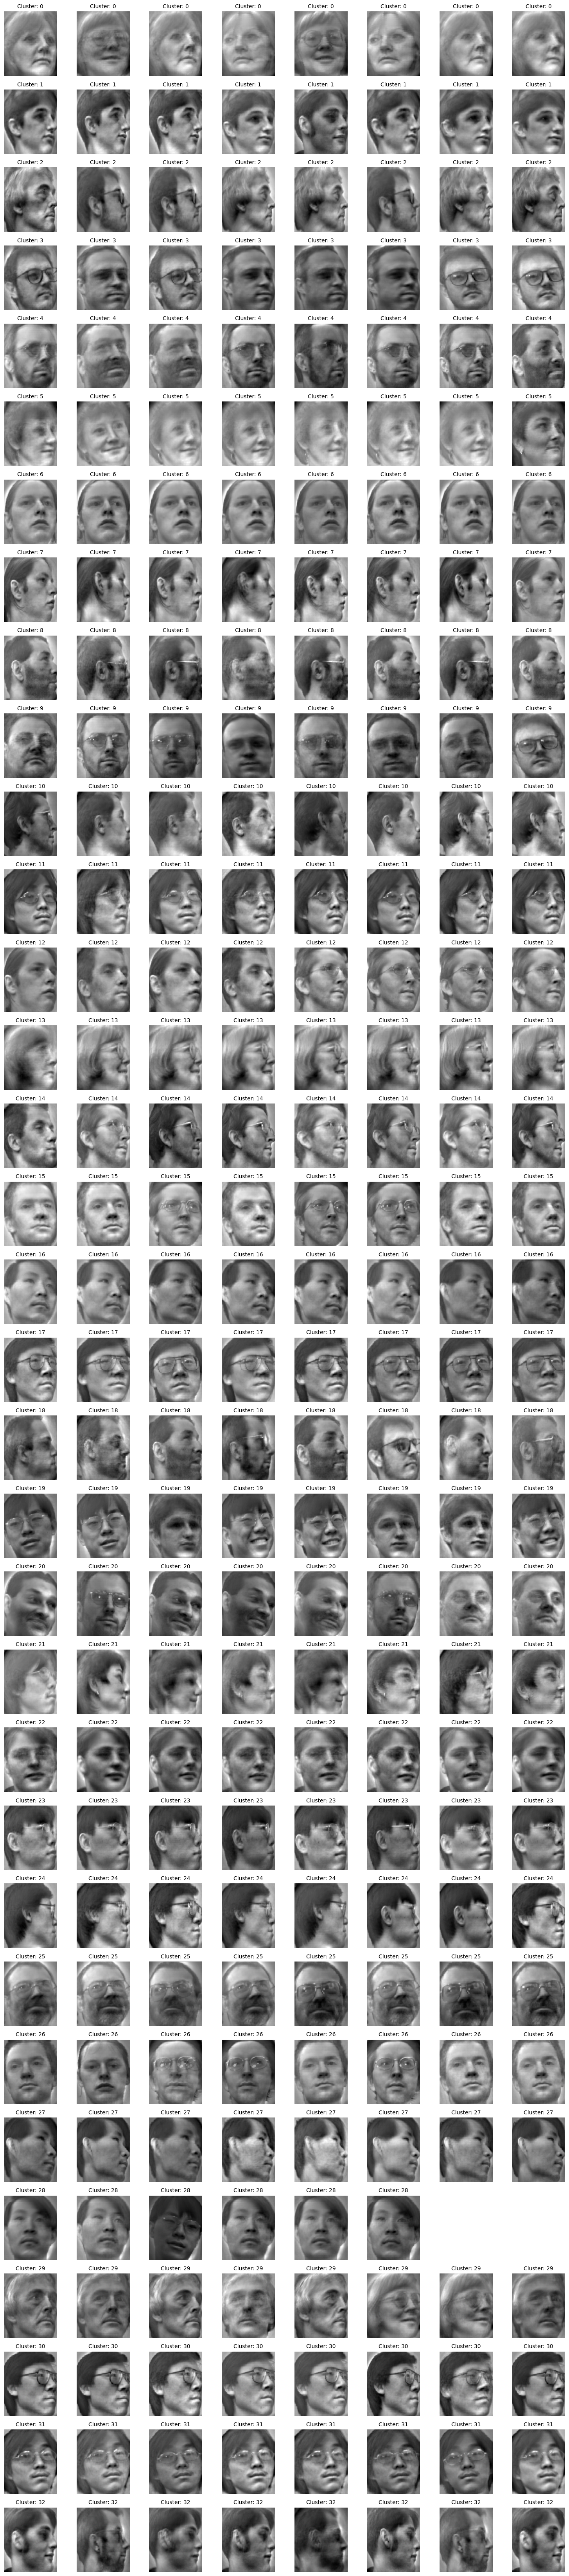

In [ ]:
X_train_reconstructed = pca.inverse_transform(X_train)


y_kmeans_unique = np.unique(y_kmeans)
plt.figure(figsize=(15, len(y_kmeans_unique) * 2))  # Adjust the figure size as needed

for i, cluster in enumerate(y_kmeans_unique):
    indices = np.where(y_kmeans == cluster)[0]
    for j, index in enumerate(indices):
        if j >= 8:  # Limit to 8 images per cluster for better visualization
            break
        plt.subplot(len(y_kmeans_unique), 8, i * 8 + j + 1)
        plt.imshow(np.reshape(X_train_reconstructed[index], (112, 92)), cmap=plt.cm.gray)
        plt.title('Cluster: ' + str(cluster), fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()
